In [1]:
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
list_label = ['Kyberge_blanket1',
              'Kyberge_blanket2', 
              'Kyberge_canvas1',
              'Kyberge_ceiling1',
              'Kyberge_ceiling2',
              'brown_bread',
              'aluminium_foil',
              'cotton',
              'KTH_cracker',
              'Kyberge_floor2']
'''list_label = []
for img in os.listdir("P:/Projects/PythonProjects/ProjectsAI/ImageProcessing/TextureClassification/Splited/train"):
    list_label.append(img)'''
img_size = 200


def get_data(data_dir, labels):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_number = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                gray_scaled = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)
                resized_image = cv2.resize(gray_scaled, (img_size, img_size))
                data.append([resized_image, class_number])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_data('Splited/train',list_label)
x_train = []
y_train = []
for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
print(len(train))

1026


p:\projects\pythonprojects\projectsai\venv\lib\site-packages\ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [4]:
val = get_data('Splited/valid',list_label)

x_val=[]
y_val=[]
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
print(len(val))

1028


p:\projects\pythonprojects\projectsai\venv\lib\site-packages\ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [5]:
def generate_bank_filter(num_kernels, ksize=(25, 25), lambd=6, psi=0):
    bank = []
    step = np.pi / num_kernels
    for index in range(num_kernels):
        theta = index * step
        for sigma in (2,4,6):
            for gamma in (0.25, 0.5):
                kernel = cv2.getGaborKernel(ksize=ksize, sigma=sigma, theta=theta, lambd=lambd, gamma=gamma, psi=psi)
                kernel /= 1.5*kernel.sum()
                bank.append(kernel)
    return bank

In [6]:
bank = generate_bank_filter(num_kernels=4)
print(len(bank))

24


Text(0.5, 1.0, 'Kyberge_blanket1')

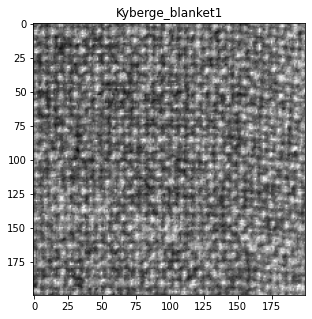

In [7]:
plt.figure(figsize = (5,5))
plt.imshow(x_train[50],cmap='gray')
plt.title(list_label[y_train[50]])

In [8]:
'''for i in range(6):
    
img1 = cv2.filter2D(x_train[0], ddepth=-1, kernel=bank[0])
img2 = cv2.filter2D(x_train[0], ddepth=-1, kernel=bank[1])
img = 255- np.ones((200,50), dtype=np.uint8)
new = np.concatenate((img1,img, img2), axis=1)
plt.imshow(new,cmap='gray')'''

"for i in range(6):\n    \nimg1 = cv2.filter2D(x_train[0], ddepth=-1, kernel=bank[0])\nimg2 = cv2.filter2D(x_train[0], ddepth=-1, kernel=bank[1])\nimg = 255- np.ones((200,50), dtype=np.uint8)\nnew = np.concatenate((img1,img, img2), axis=1)\nplt.imshow(new,cmap='gray')"

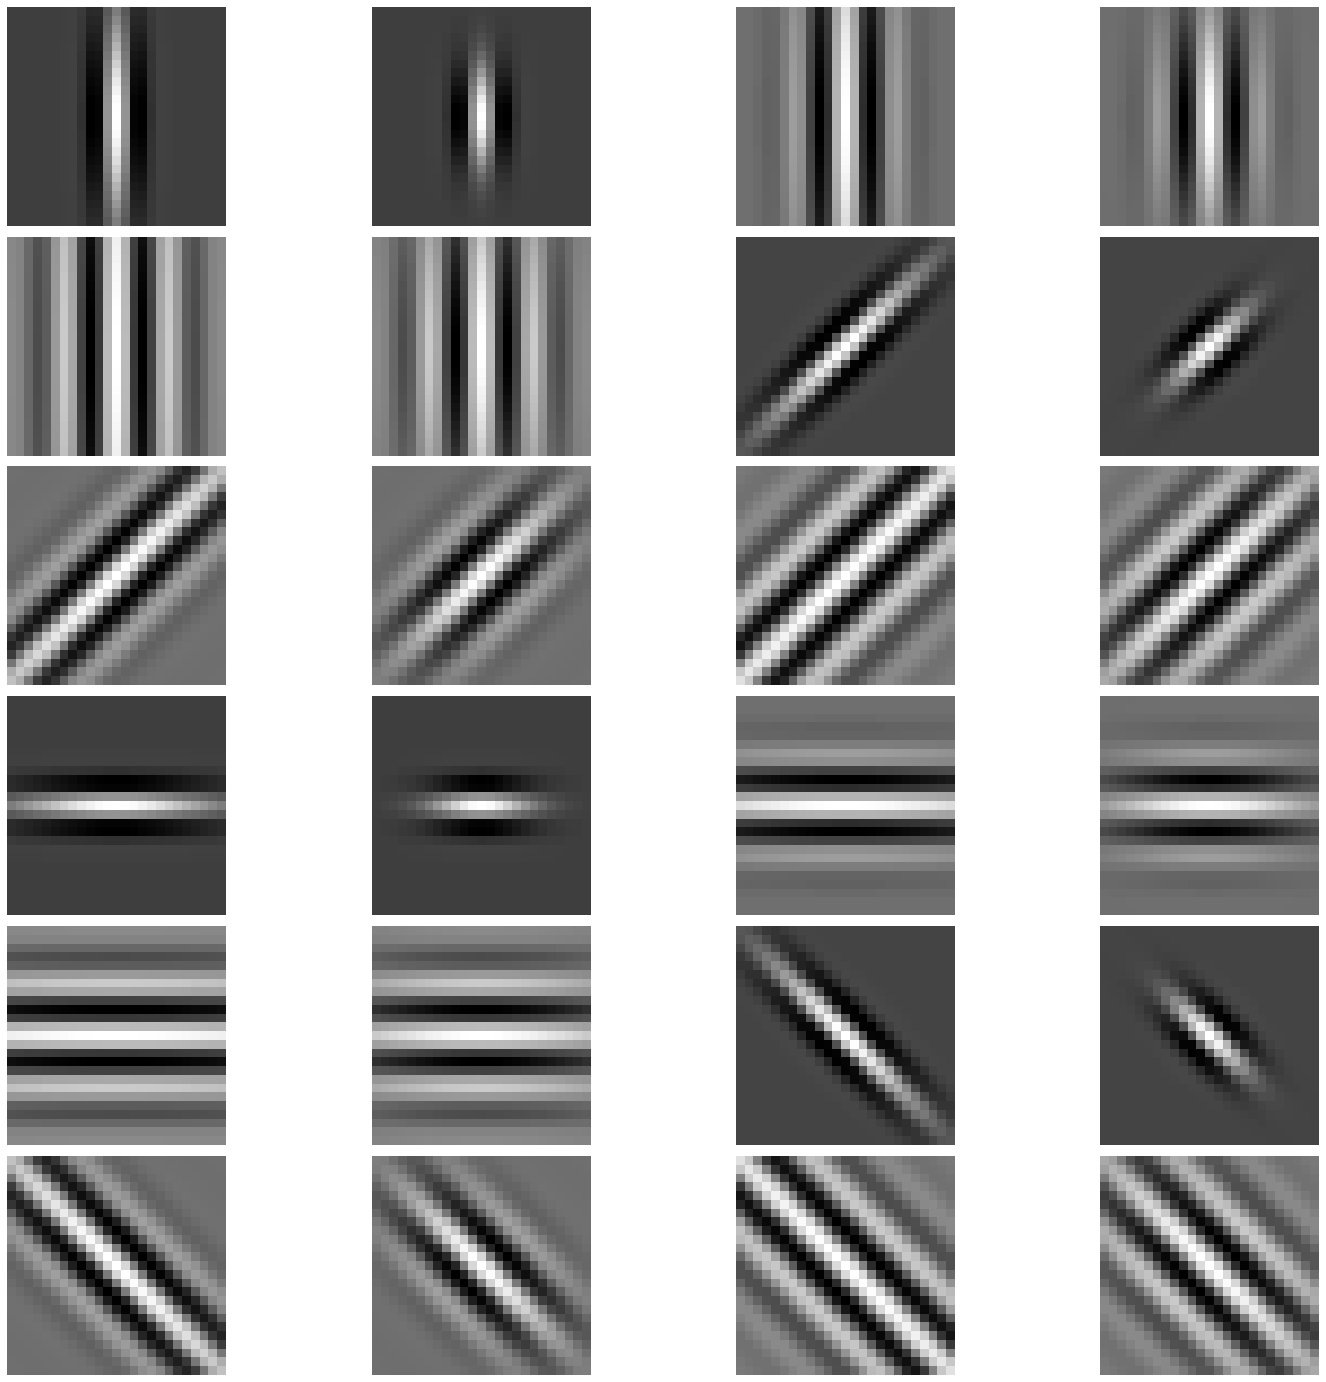

In [9]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))
plt.gray()
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
i=0
statics = np.zeros((len(bank), 1), dtype=np.float64)
axes[0][0].axis('off')
for ax_row in axes[0:]:
    ax = ax_row[0]
    ax.set_xticks([])
    ax.set_yticks([])
    for ax in ax_row[0:]:
        ax.imshow(bank[i])
        ax.axis('off')
        i+=1

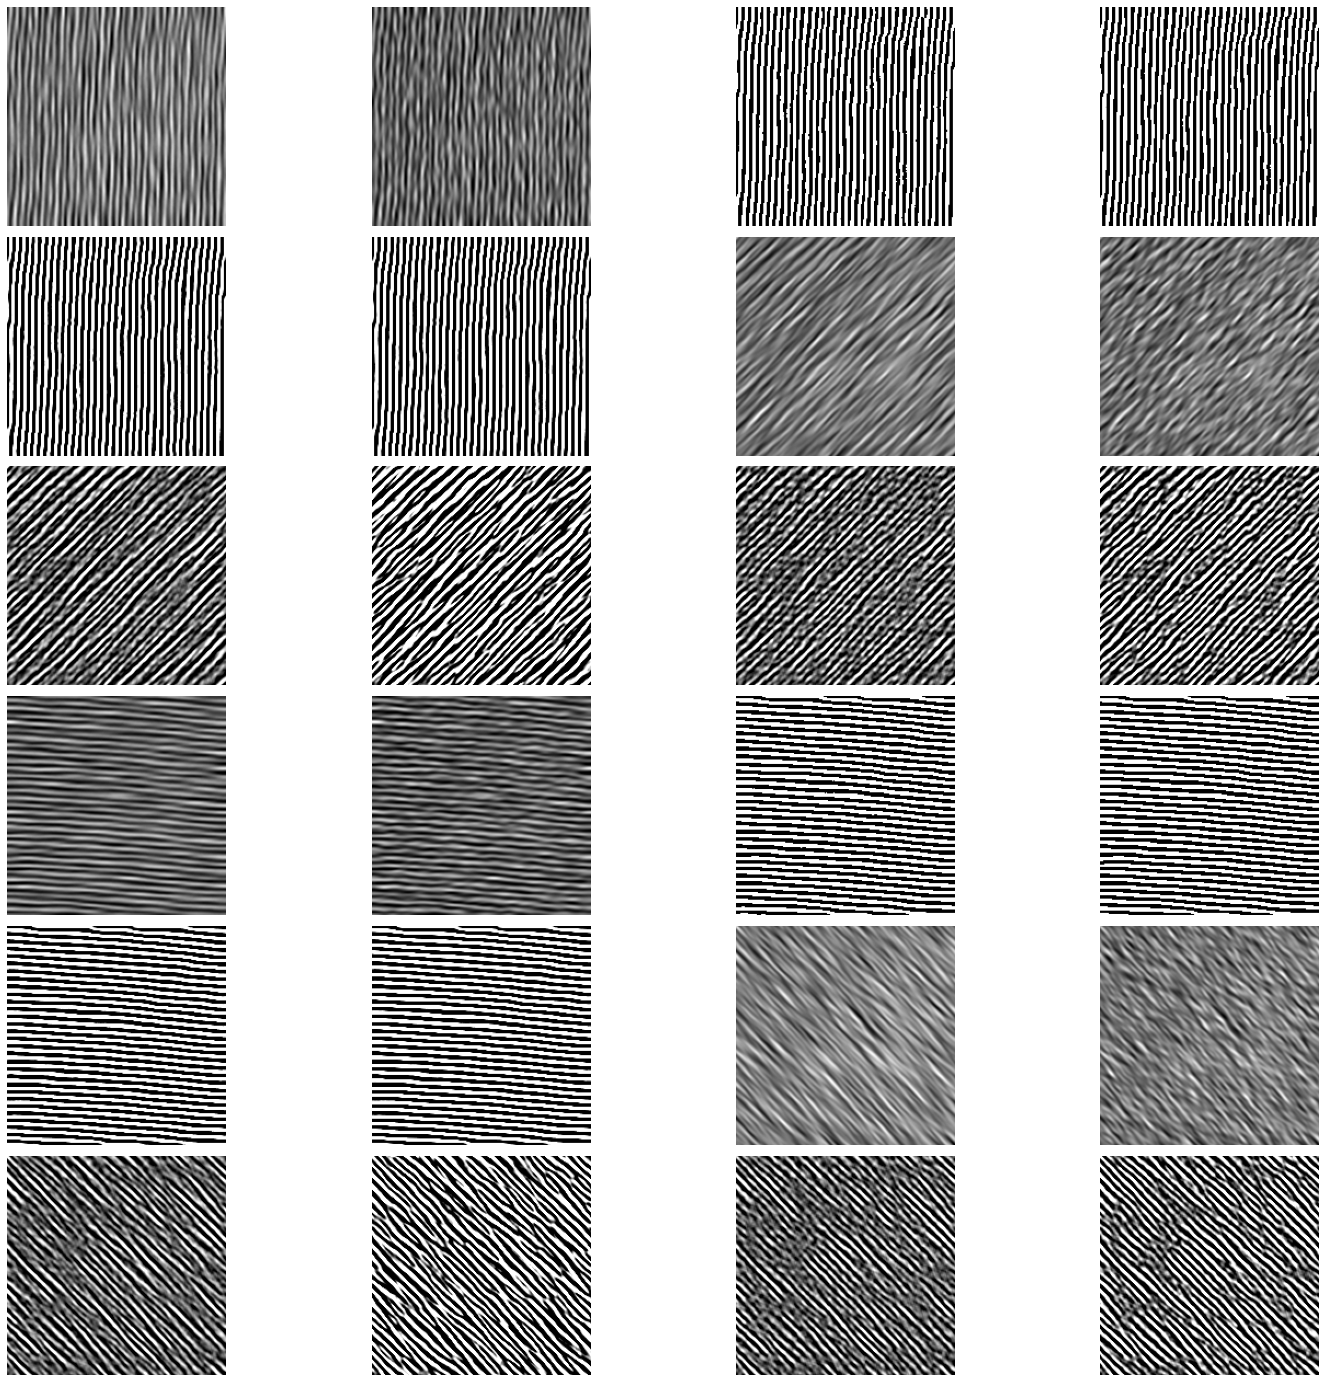

In [10]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))
plt.gray()
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
i=0
statics = np.zeros((len(bank), 1), dtype=np.float64)
axes[0][0].axis('off')
for ax_row in axes[0:]:
    ax = ax_row[0]
    ax.set_xticks([])
    ax.set_yticks([])
    for ax in ax_row[0:]:
        new_image = cv2.filter2D(x_train[0], ddepth=-1, kernel = bank[i])
        new_image= new_image/255
        statics[i] = new_image.mean()
        ax.imshow(new_image)
        ax.axis('off')
        i+=1

In [11]:
def feature_extraction1(x_train, bank):
    new_x_train = []
    for img in x_train:
        static = np.zeros((len(bank), 1), dtype=np.float64)
        for i, kernel in enumerate(bank):
            new_image = cv2.filter2D(img, ddepth=-1, kernel = kernel)
            new_image= new_image/255
            static[i] = new_image.mean()
        new_x_train.append(np.transpose(static))
    X_train = np.array(new_x_train)
    X_train = np.squeeze(X_train)
    return X_train

In [12]:
X_train =  feature_extraction1(x_train,bank)

In [13]:
print(X_train.shape)

(1026, 24)


In [14]:
X_val = feature_extraction1(x_val,bank)

In [15]:
def feature_extract_of_image1(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    resized_image = cv2.resize(gray, (224, 224))
    feature = np.zeros((len(bank), 1), dtype=np.float64)
    for i, kernel in enumerate(bank):
        new_image = cv2.filter2D(resized_image, ddepth=-1, kernel = kernel)
        new_image= new_image/255
        feature[i] = new_image.mean()
    features = np.array(feature)
    return np.reshape(features, (1, 24))

In [48]:
from sklearn.neighbors import KNeighborsClassifier
Kclassifer = KNeighborsClassifier(n_neighbors=10, p=2, weights='distance')
Kclassifer.fit(X_train, y_train)
accuracy = Kclassifer.score(X_val,y_val)
print(accuracy)

0.9445525291828794


In [17]:
path = "P:/Projects/PythonProjects/ProjectsAI/ImageProcessing/TextureClassification/Splited/valid/Kyberge_ceiling2"
for img in os.listdir(path):
    try:
        full_path = os.path.join(path, img)
        img_pred = feature_extract_of_image1(full_path)
        print(list_label[Kclassifer.predict(img_pred)[0]])
    except Exception as e:
        print(e)

Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
aluminium_foil
Kyberge_ceiling2
aluminium_foil
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
Kyberge_ceiling2
K

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [19]:
predictions = Kclassifer.predict(X_val)
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        80
           1       0.96      0.99      0.98        80
           2       0.93      1.00      0.96        80
           3       1.00      1.00      1.00        80
           4       1.00      1.00      1.00        80
           5       0.73      0.46      0.57        41
           6       0.90      0.96      0.93       216
           7       0.97      0.93      0.95       257
           8       0.67      0.59      0.62        34
           9       0.96      1.00      0.98        80

    accuracy                           0.94      1028
   macro avg       0.91      0.89      0.90      1028
weighted avg       0.94      0.94      0.94      1028



In [20]:
error_rates = []

for i in np.arange(1, 101):

    new_model = KNeighborsClassifier(n_neighbors = i,p=2, weights='distance')

    new_model.fit(X_train, y_train)

    new_predictions = new_model.predict(X_val)

    error_rates.append(np.mean(new_predictions != y_val))


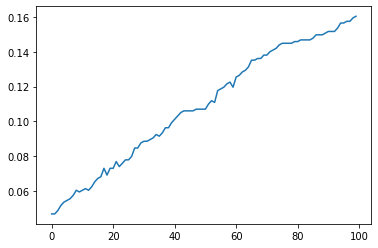

In [21]:
plt.plot(error_rates)

In [22]:
clf_SVC1 = SVC(kernel = 'linear', C=1.0, random_state=42)
clf_SVC1.fit(X_train, y_train)
accuracy = clf_SVC1.score(X_val,y_val)
print(accuracy)

0.5603112840466926


In [23]:
clf_SVC2 = SVC(kernel = 'rbf', gamma = 1)
clf_SVC2.fit(X_train, y_train)
accuracy = clf_SVC2.score(X_val,y_val )
print(accuracy)

0.7149805447470817


In [24]:
path = "P:/Projects/PythonProjects/ProjectsAI/ImageProcessing/TextureClassification/Splited/valid/Kyberge_blanket2"
for img in os.listdir(path):
    try:
        full_path = os.path.join(path, img)
        img_pred = feature_extract_of_image1(full_path)
        print(list_label[clf_SVC2.predict(img_pred)[0]])
    except Exception as e:
        print(e)

cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton
cotton


In [25]:
from sklearn.manifold import TSNE
import seaborn as sns

p:\projects\pythonprojects\projectsai\venv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
p:\projects\pythonprojects\projectsai\venv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


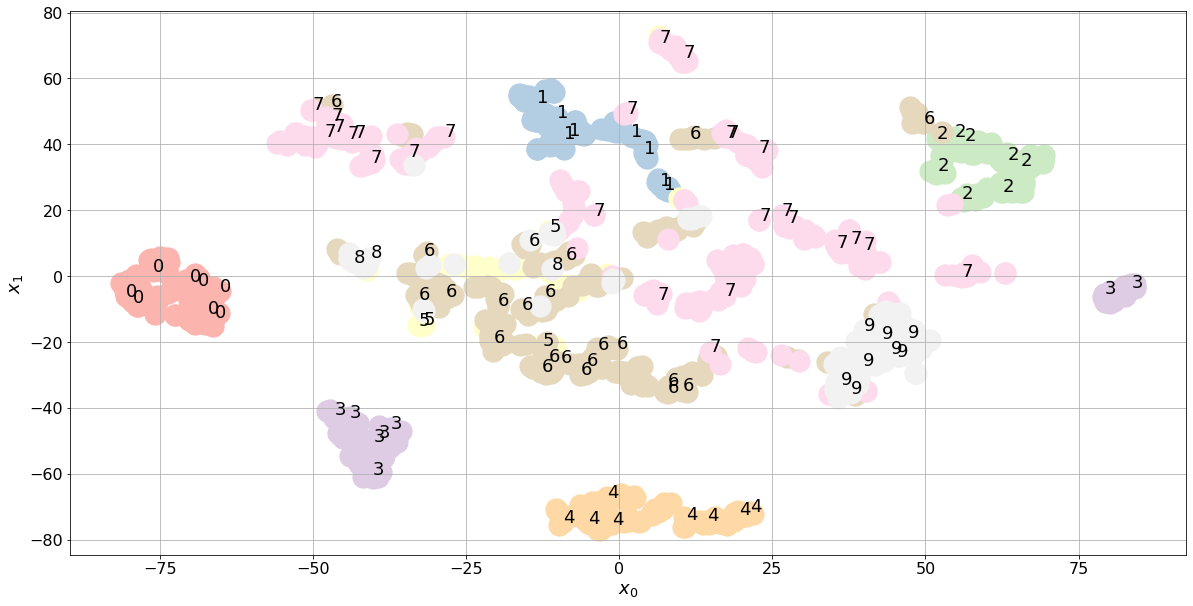

In [26]:
import matplotlib.cm as cm
tsne = TSNE(n_components=2, perplexity=10.0, random_state=1000)
X_tsne = tsne.fit_transform(X_train)

fig, ax = plt.subplots(figsize=(20, 10))

    # Show the t-SNE clustered dataset
for i in range(X_tsne.shape[0]):
    ax.scatter(X_tsne[i, 0], X_tsne[i, 1], marker='o', color=cm.Pastel1(y_train[i]), s=450)
    if i % 10 == 0:
        ax.annotate('%d' % y_train[i], xy=(X_tsne[i, 0], X_tsne[i, 1]), fontsize=18)

ax.set_xlabel(r'$x_0$', fontsize=18)
ax.set_ylabel(r'$x_1$', fontsize=18)

for t in ax.xaxis.get_major_ticks():
    t.label.set_fontsize(16)

for t in ax.yaxis.get_major_ticks():
    t.label.set_fontsize(16)

ax.grid(True)

plt.show()

In [27]:
kernels = []
for theta in (0,np.pi/4, np.pi/2, 2*np.pi/3):
    #for frequency in (0.05, 0.1):
    for sigma in (5,7,9,11,15):
        kernel = gabor_kernel(frequency=0.05, theta=theta,sigma_x=sigma, sigma_y=sigma)
        print(kernel.shape)
        kernels.append(kernel)

(31, 31)
(43, 43)
(55, 55)
(67, 67)
(91, 91)
(23, 23)
(31, 31)
(41, 41)
(49, 49)
(65, 65)
(31, 31)
(43, 43)
(55, 55)
(67, 67)
(91, 91)
(27, 27)
(39, 39)
(49, 49)
(59, 59)
(79, 79)


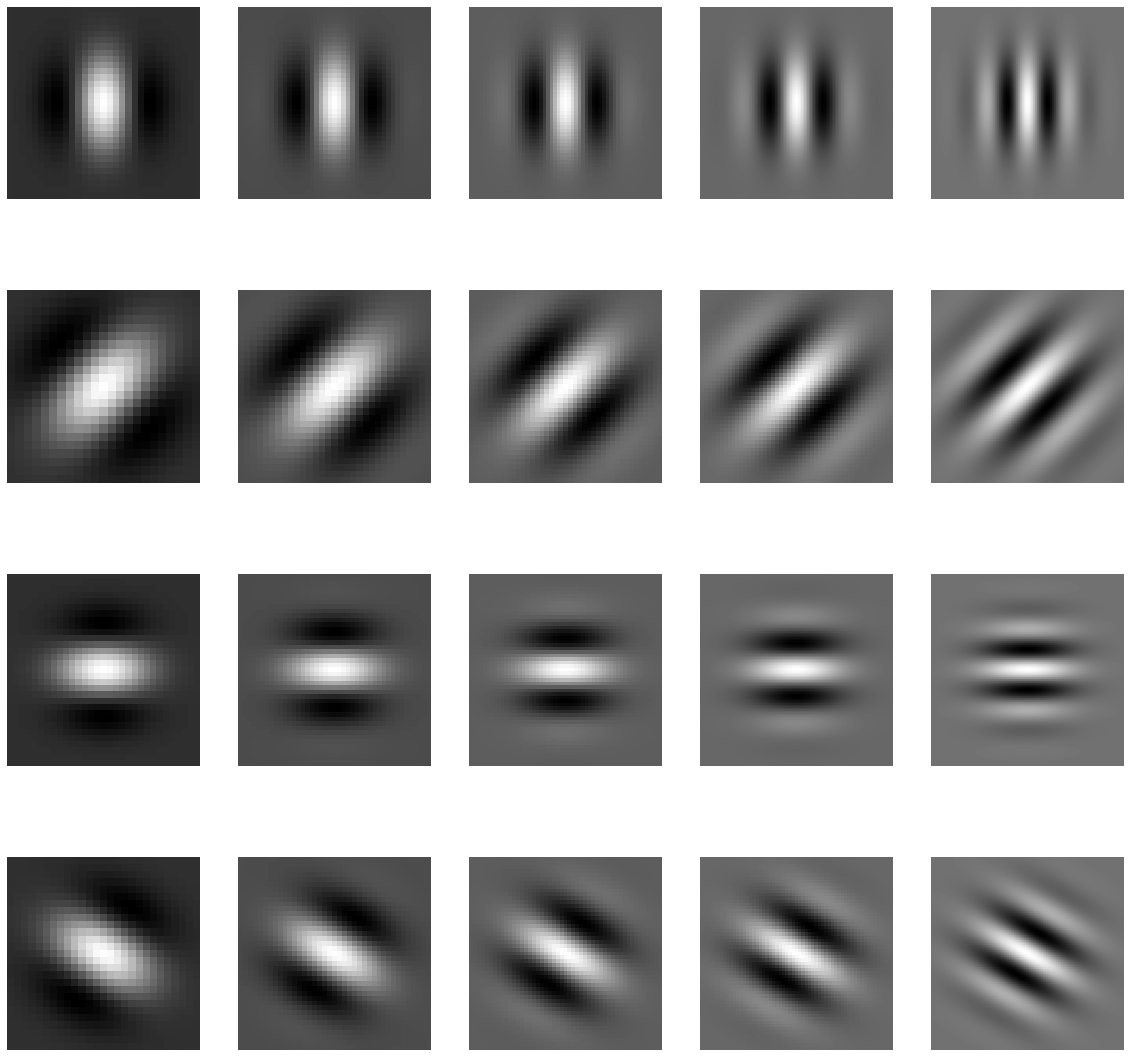

In [28]:
fig, axes = plt.subplots(nrows=4, ncols=int(len(kernels)/4), figsize=(20, 20))
plt.gray()
i=0
axes[0][0].axis('off')
for ax_row in axes[0:]:
    ax = ax_row[0]
    ax.set_xticks([])
    ax.set_yticks([])
    for ax in ax_row[0:]:
        ax.imshow(np.real(kernels[i]))
        ax.axis('off')
        i+=1

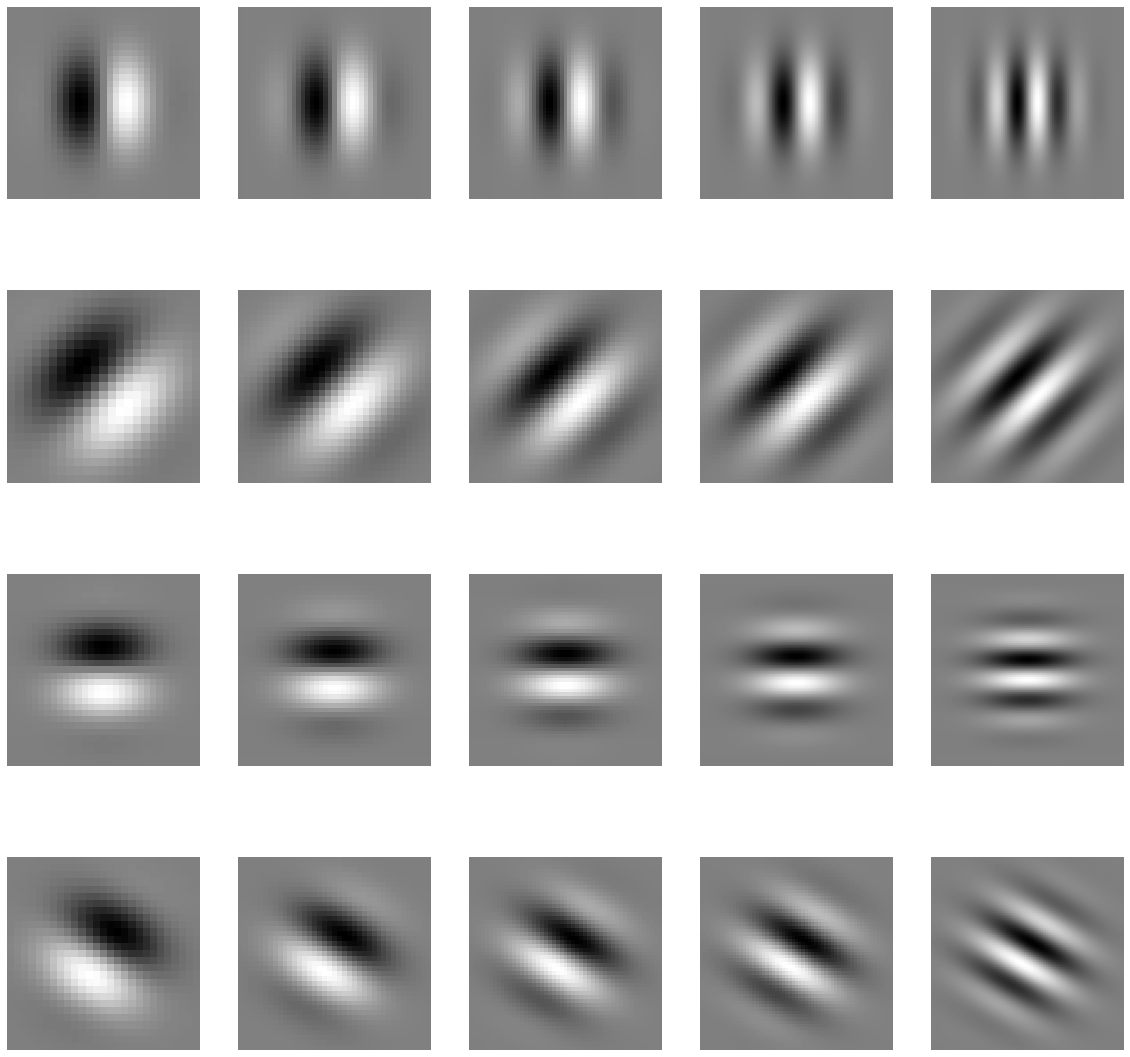

In [50]:
fig, axes = plt.subplots(nrows=4, ncols=int(len(kernels)/4), figsize=(20, 20))
plt.gray()
i=0
axes[0][0].axis('off')
for ax_row in axes[0:]:
    ax = ax_row[0]
    ax.set_xticks([])
    ax.set_yticks([])
    for ax in ax_row[0:]:
        ax.imshow(np.imag(kernels[i]))
        ax.axis('off')
        i+=1

In [29]:
test = x_train[100]
real_result = ndi.convolve(test, np.real(kernels[-1]), mode='wrap')
imag_result = ndi.convolve(test, np.imag(kernels[-1]), mode='wrap')

new_image = np.sqrt(real_result**2 + imag_result**2)
new_image = np.array(new_image,np.uint8)

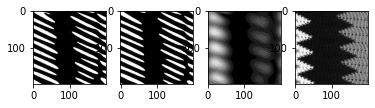

In [30]:
axe1 = plt.subplot(141)
axe1.imshow(real_result, cmap = 'gray')
axe2 = plt.subplot(142)
axe2.imshow(imag_result, cmap = 'gray')
axe3 = plt.subplot(143)
axe3.imshow(new_image, cmap = 'gray')
axe4 = plt.subplot(144)
axe4.imshow(test, cmap = 'gray')

Text(0.5, 1.0, 'Kyberge_blanket1')

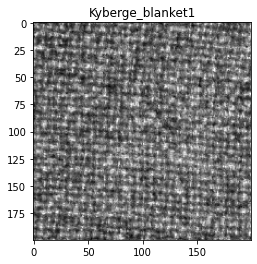

In [31]:
plt.imshow(x_train[0], cmap = 'gray')
plt.title(list_label[train[0][1]])

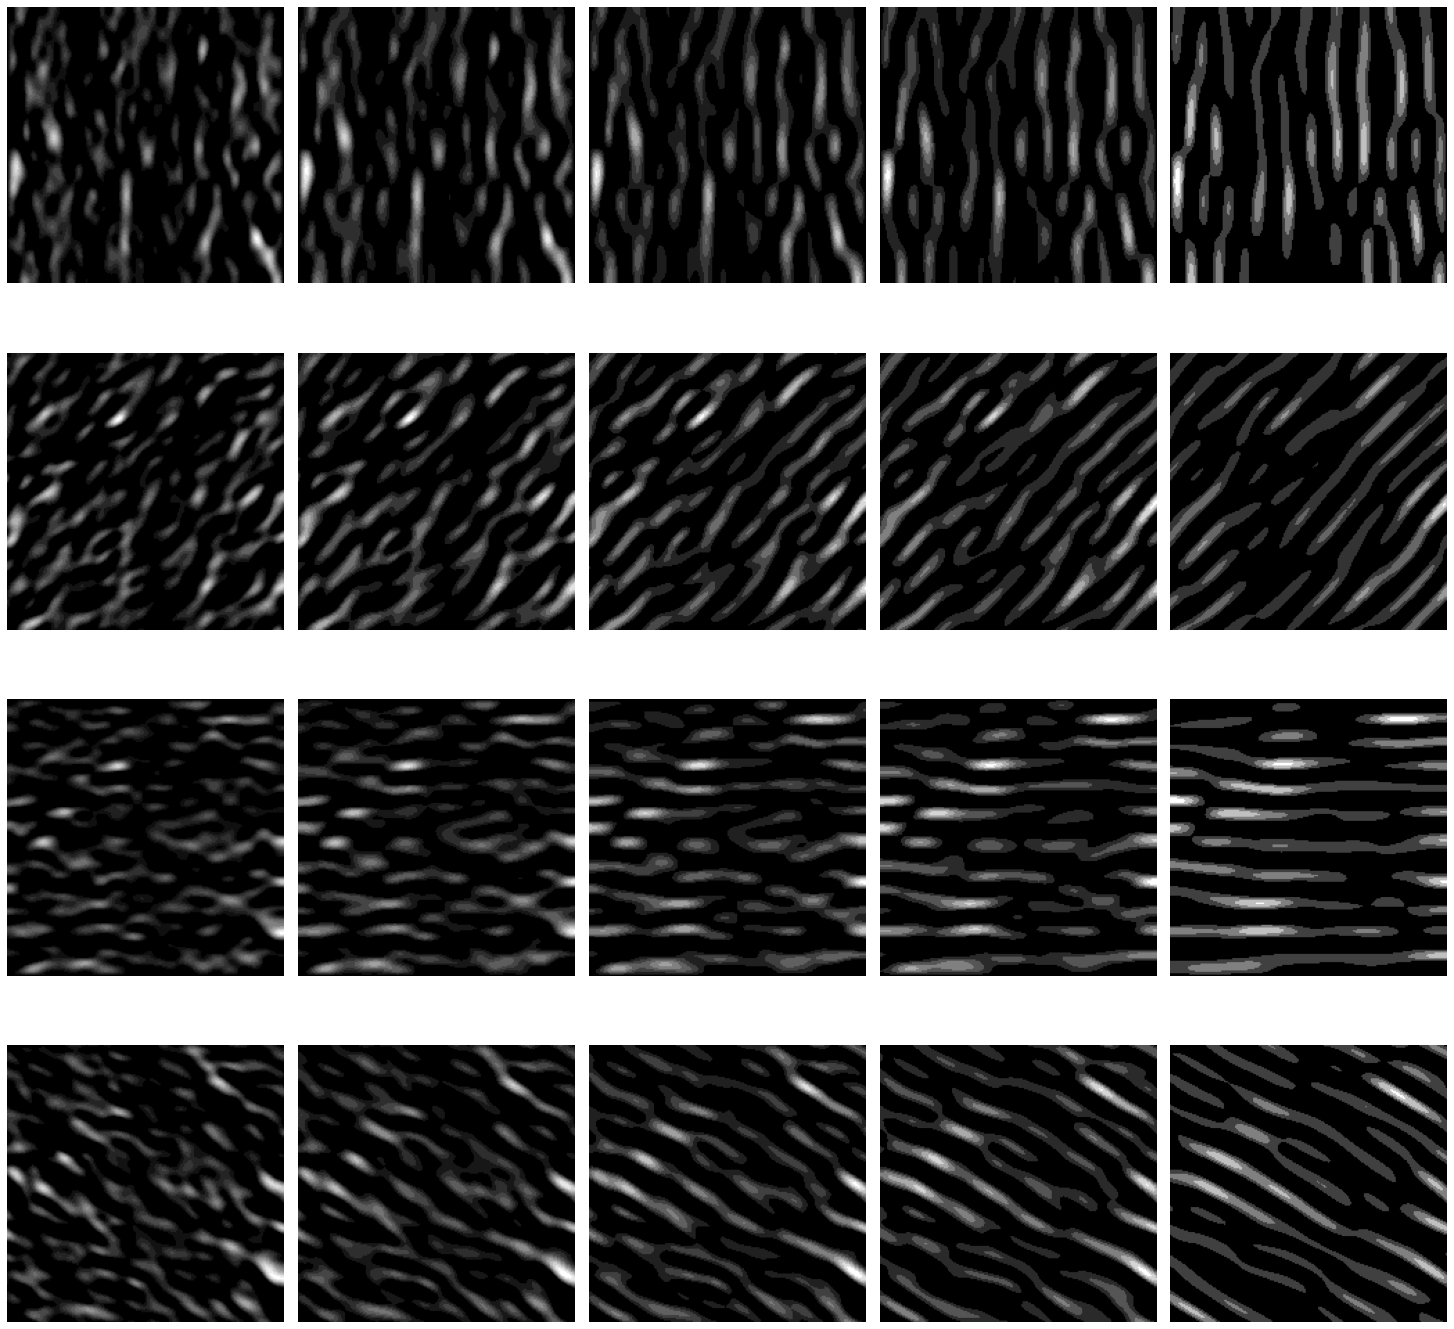

In [32]:
fig, axes = plt.subplots(nrows=4, ncols=int(len(kernels)/4), figsize=(20, 20))
plt.gray()
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
i=0
statics = np.zeros((len(kernels), 1), dtype=np.float64)
axes[0][0].axis('off')
for ax_row in axes[0:]:
    ax = ax_row[0]
    ax.set_xticks([])
    ax.set_yticks([])
    for ax in ax_row[0:]:
        real_filter = cv2.filter2D(x_train[-1], ddepth=-1,kernel= np.real(kernels[i]))
        imag_filter = cv2.filter2D(x_train[-1], ddepth=-1,kernel= np.imag(kernels[i]))
        new_image = np.sqrt(real_filter**2 + imag_filter**2)
        new_image = np.array(new_image, np.uint8)
        statics[i] = new_image.var()
        ax.imshow(imag_filter)
        ax.axis('off')
        i+=1


In [33]:
print(statics)

[[15.48321535]
 [ 9.48348079]
 [ 3.25742994]
 [ 1.4683135 ]
 [ 0.77983378]
 [14.76599364]
 [14.04935694]
 [ 2.6797837 ]
 [ 1.15705325]
 [ 0.61760759]
 [15.82549623]
 [ 9.03077788]
 [ 3.27005184]
 [ 1.54564857]
 [ 0.86245444]
 [15.14096578]
 [ 9.1325119 ]
 [ 3.11915438]
 [ 1.48480382]
 [ 0.63060188]]


In [34]:
def apply_gabor_filter(image, kernels):
    feature_vector = []
    for i, kernel in enumerate(kernels):
        real_filter = cv2.filter2D(image, ddepth=-1,kernel= np.real(kernel))
        imag_filter = cv2.filter2D(image, ddepth=-1,kernel= np.imag(kernel))
        new_image = np.sqrt(real_filter**2 + imag_filter**2)
        new_image = np.array(new_image, np.uint8)
        feature_vector.append(new_image.mean())
    return np.squeeze(feature_vector)

In [35]:
def feature_extract(x_train, banks):
    X_train = []
    for image in x_train:
        feature_vector = apply_gabor_filter(image,banks)
        X_train.append(feature_vector)
    X_train = np.array(X_train)
    return np.squeeze(X_train)

In [36]:
def get_test_data(data_dir, label, banks):
    x_test,y_test =[],[]
    path = os.path.join(data_dir, label)
    class_index = list_label.index(label)
    for img in os.listdir(path):
        try:
            img_arr = cv2.imread(os.path.join(path, img))
            gray_scaled = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)
            resized_image = cv2.resize(gray_scaled, (200, 200))
            feature_vector = apply_gabor_filter(resized_image,banks)
            x_test.append(feature_vector)
            y_test.append(class_index)
        except Exception as e:
            print(e)
    x_test = np.array(x_test)
    return np.squeeze(x_test),y_test

In [42]:
X_train =  feature_extract(x_train, kernels)
X_val = feature_extract(x_val, kernels)
print(X_train.shape)
print(X_val.shape)

(1026, 20)
(1028, 20)


In [38]:
knn = KNeighborsClassifier(n_neighbors=10,p=2,weights='distance')

knn.fit(  X_train, y_train  )

predictions = knn.predict(X_val)

print(accuracy_score(y_val, predictions))
print(classification_report(y_val, predictions))

0.9445525291828794
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        80
           1       1.00      0.93      0.96        80
           2       0.98      1.00      0.99        80
           3       0.99      1.00      0.99        80
           4       0.93      1.00      0.96        80
           5       0.72      0.83      0.77        41
           6       0.96      0.98      0.97       216
           7       1.00      0.96      0.98       257
           8       0.85      0.50      0.63        34
           9       0.91      0.89      0.90        80

    accuracy                           0.94      1028
   macro avg       0.92      0.90      0.90      1028
weighted avg       0.95      0.94      0.94      1028



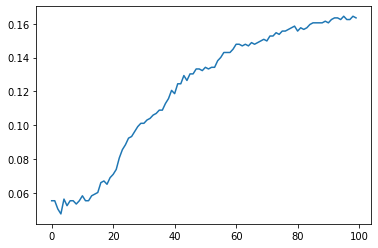

In [47]:
error_rates = []

for i in np.arange(1, 101):

    new_model = KNeighborsClassifier(n_neighbors = i,p=2, weights='distance')

    new_model.fit(X_train, y_train)

    new_predictions = new_model.predict(X_val)

    error_rates.append(np.mean(new_predictions != y_val))
    
plt.plot(error_rates)

In [49]:
clf_SVC1 = SVC(kernel = 'linear', C=1.0, random_state=42)
clf_SVC1.fit(X_train, y_train)
accuracy = clf_SVC1.score(X_val,y_val)
print(accuracy)

0.9202334630350194


In [45]:
#['Kyberge_blanket1','Kyberge_blanket2', 'Kyberge_canvas1','Kyberge_ceiling1', 'Kyberge_ceiling2','brown_bread','aluminium_foil']
#path = "P:/Projects/PythonProjects/ProjectsAI/ImageProcessing/TextureClassification/Splited/valid"
test_x, test_y = get_test_data("Splited/valid", "Kyberge_ceiling2", kernels)

In [46]:
predictions = knn.predict(test_x)
print(accuracy_score(test_y, predictions))

1.0


p:\projects\pythonprojects\projectsai\venv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
p:\projects\pythonprojects\projectsai\venv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


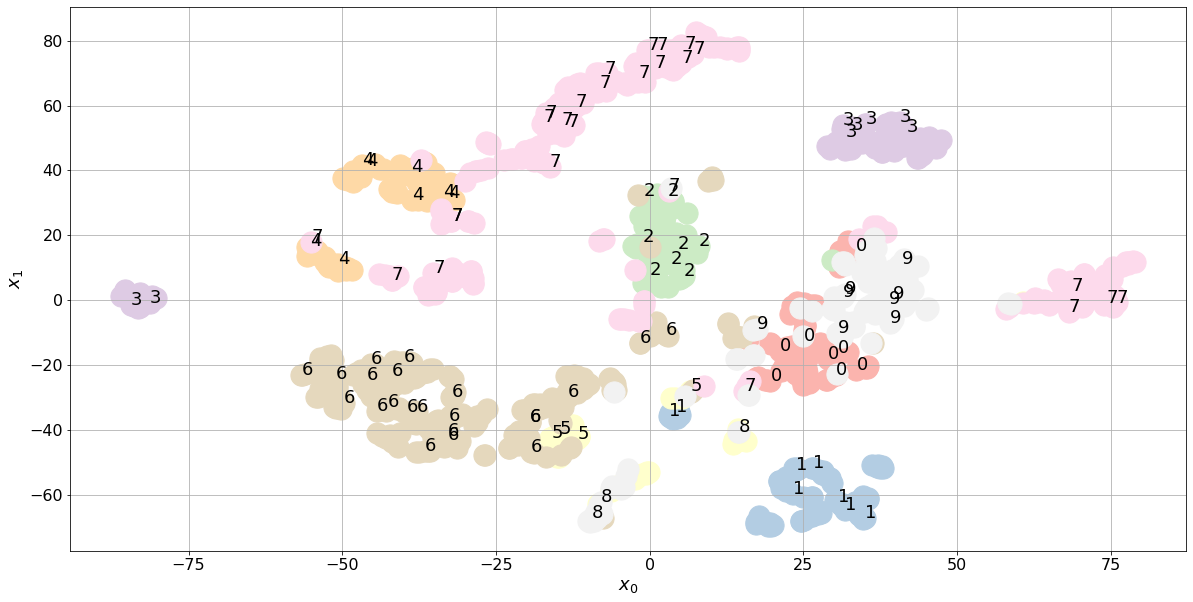

In [41]:
tsne = TSNE(n_components=2, perplexity=10.0, random_state=1000)
X_tsne = tsne.fit_transform(X_train)

fig, ax = plt.subplots(figsize=(20, 10))

    # Show the t-SNE clustered dataset
for i in range(X_tsne.shape[0]):
    ax.scatter(X_tsne[i, 0], X_tsne[i, 1], marker='o', color=cm.Pastel1(y_train[i]), s=450)
    if i % 10 == 0:
        ax.annotate('%d' % y_train[i], xy=(X_tsne[i, 0], X_tsne[i, 1]), fontsize=18)

ax.set_xlabel(r'$x_0$', fontsize=18)
ax.set_ylabel(r'$x_1$', fontsize=18)

for t in ax.xaxis.get_major_ticks():
    t.label.set_fontsize(16)

for t in ax.yaxis.get_major_ticks():
    t.label.set_fontsize(16)

ax.grid(True)

plt.show()